In [1]:
from IPython.display import clear_output, display

import time
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('pandas version: {}'.format(pd.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in /Users/ralf/.virtualenvs/flopy/lib/python3.7/site-packages/flopy
3.7.7 (default, Mar 10 2020, 15:43:33) 
[Clang 11.0.0 (clang-1100.0.33.17)]
numpy version: 1.18.3
matplotlib version: 3.2.1
pandas version: 1.0.3
flopy version: 3.3.0


### Model inputs

In [2]:
# load the model
project_name = "UMONS_SmallModel_SteadyState"
model_ws = os.path.join('.', "SteadyState")
ml = flopy.modflow.Modflow.load(
    project_name+".mfn", 
    model_ws=model_ws, 
    verbose=True,
    check=False, 
    exe_name="mf2000"
)


Creating new model with name: UMONS_SmallModel_SteadyState
--------------------------------------------------

Parsing the namefile --> ./SteadyState/UMONS_SmallModel_SteadyState.mfn

--------------------------------------------------
External unit dictionary:
{7: filename:./SteadyState/UMONS_SmallModel_SteadyState.obs, filetype:OBS, 8: filename:./SteadyState/UMONS_SmallModel_SteadyState.chob, filetype:CHOB, 9: filename:./SteadyState/UMONS_SmallModel_SteadyState.dis, filetype:DIS, 10: filename:./SteadyState/UMONS_SmallModel_SteadyState.ba6, filetype:BAS6, 11: filename:./SteadyState/UMONS_SmallModel_SteadyState.lpf, filetype:LPF, 12: filename:./SteadyState/UMONS_SmallModel_SteadyState.oc, filetype:OC, 13: filename:./SteadyState/UMONS_SmallModel_SteadyState.rch, filetype:RCH, 16: filename:./SteadyState/UMONS_SmallModel_SteadyState.wel, filetype:WEL, 14: filename:./SteadyState/UMONS_SmallModel_SteadyState.chd, filetype:CHD, 15: filename:./SteadyState/UMONS_SmallModel_SteadyState.pcg, fil

In [3]:
ml.dis.sr

xul:0; yul:11017.70536; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

plotting LPF package Util3d instance: hk
plotting LPF package Util3d instance: hani
plotting LPF package Util3d instance: vka
plotting LPF package Util3d instance: ss
plotting LPF package Util3d instance: sy
plotting LPF package Util3d instance: vkcb
plotting LPF package Util3d instance: wetdry


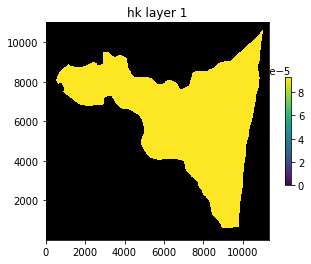

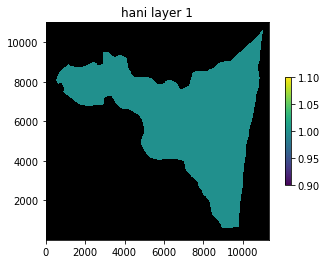

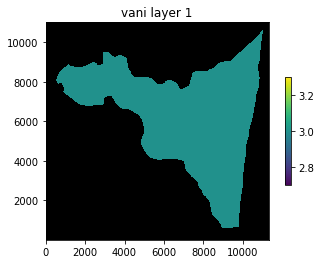

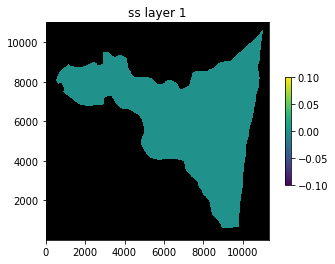

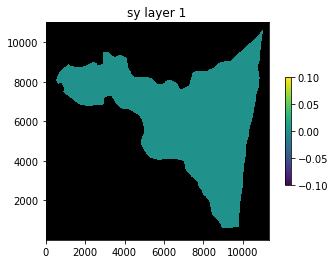

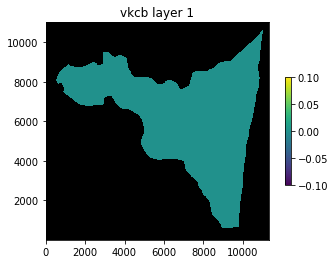

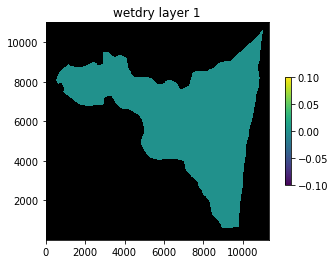

In [4]:
ml.lpf.plot()

plotting DIS package Util2d instance: top
plotting DIS package Util3d instance: botm
plotting DIS package Util3d instance: _ModflowDis__thickness


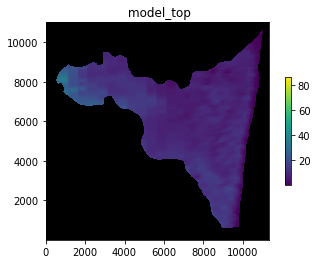

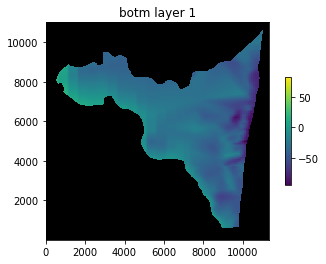

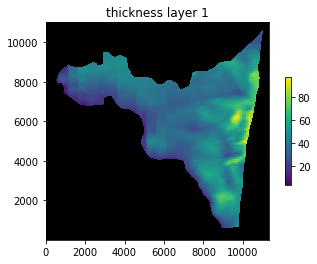

In [5]:
ml.dis.plot()

In [6]:
ml.dis.export(os.path.join(model_ws, project_name+".shp"))

wrote ./SteadyState/UMONS_SmallModel_SteadyState.shp


In [7]:
ml.write_input()


Writing packages:
   Package:  DIS
   Package:  CHOB
   Package:  BAS6
   Package:  LPF
   Package:  OC
   Package:  RCH
   Package:  WEL
   Package:  CHD
   Package:  PCG
 


In [8]:
ml.run_model()

FloPy is using the following  executable to run the model: /usr/local/bin/mf2000

                                  MODFLOW-2000
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.19.01 03/25/2010                      

 Using NAME file: UMONS_SmallModel_SteadyState.nam                                                                                                                                                                        
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/30 15:44:05

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/30 15:44:05
 Elapsed run time:  0.266 Seconds

 Normal termination of MODFLOW-2000


(True, [])

### Output inspection

First, lets look at the list file

In [9]:
mfl = flopy.utils.MfListBudget(os.path.join(model_ws, project_name+".list"))
df_flux, df_vol = mfl.get_dataframes(start_datetime="01-01-1979")
df_flux

,STORAGE_IN,CONSTANT_HEAD_IN,WELLS_IN,RECHARGE_IN,TOTAL_IN,STORAGE_OUT,CONSTANT_HEAD_OUT,WELLS_OUT,RECHARGE_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1979-01-01 00:00:01.000002,0.0,0.4442,0.0,0.41,0.8542,0.0,0.013441,0.8406,0.0,0.854,0.0002,0.02


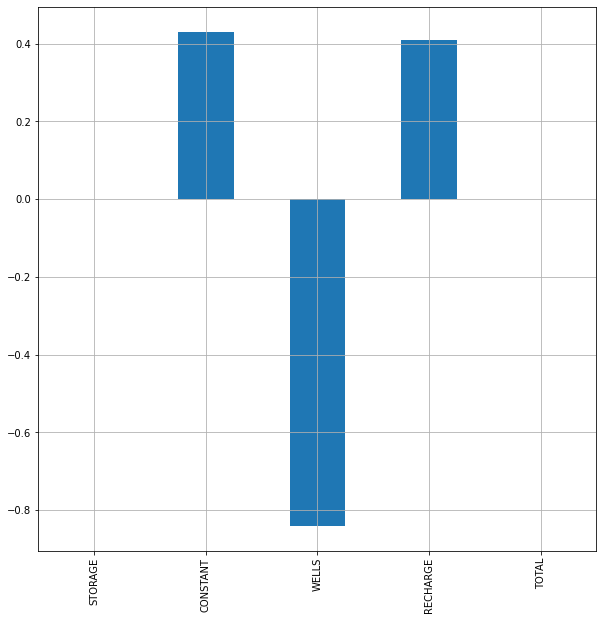

In [10]:
groups = df_flux.groupby(lambda x:x.split('_')[-1],axis=1).groups
df_flux_in = df_flux.loc[:,groups["IN"]]
df_flux_in.columns = df_flux_in.columns.map(lambda x:x.split('_')[0])

df_flux_out = df_flux.loc[:,groups["OUT"]]
df_flux_out.columns = df_flux_out.columns.map(lambda x:x.split('_')[0])


df_flux_delta = df_flux_in - df_flux_out
df_flux_delta.iloc[-1,:].plot(kind="bar",figsize=(10,10),grid=True);

### Let's look at the simulated head

In [11]:
# if you pass the model instance, then the plots will be offset and rotated
h = flopy.utils.HeadFile(os.path.join(model_ws, project_name+".hds"), model=ml)
h.times

[1.0]

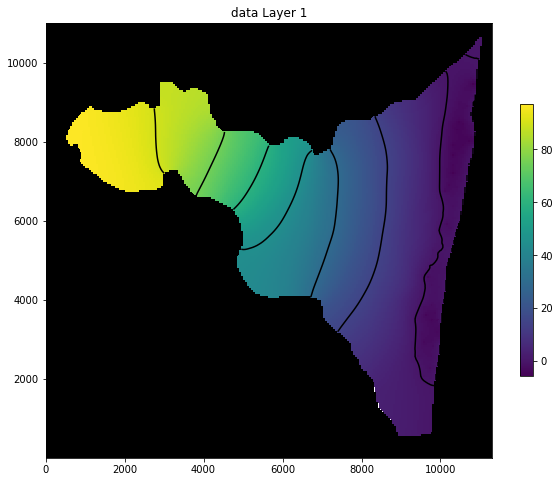

In [12]:
h.plot(totim=1, contour=True, grid=False, colorbar=True, figsize=(10,10));

### Write heads to shapefile

In [13]:
#let's write these heads to shapefile
h.to_shapefile(os.path.join(model_ws, project_name+"_head.shp"))

wrote ./SteadyState/UMONS_SmallModel_SteadyState_head.shp
